In [1]:
import gc
import numpy as np
import pandas as pd
import random
from stacking_model import ModelStacking
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [12]:
root_path = "../../../input/"

# train
train = np.load("../../data_preprocessing/new_cite_train_final.npz")["arr_0"]
train_index = np.load(f"{root_path}/multimodal-single-cell-as-sparse-matrix/train_cite_inputs_idxcol.npz",allow_pickle=True)
meta = pd.read_csv(f"{root_path}open-problems-multimodal/metadata.csv",index_col = "cell_id")
meta = meta[meta.technology=="citeseq"]
lbe = LabelEncoder()
meta["cell_type"] = lbe.fit_transform(meta["cell_type"])
meta["gender"] = meta.apply(lambda x:0 if x["donor"]==13176 else 1,axis =1)
meta_train = meta.reindex(train_index["index"])
train_meta = meta_train["cell_type"].values.reshape(-1, 1)
ohe = OneHotEncoder(sparse=False)
train_meta = ohe.fit_transform(train_meta)
train = np.concatenate([train,train_meta],axis= -1)

# target
target = pd.read_hdf(f"{root_path}open-problems-multimodal/train_cite_targets.h5").values
target -= target.mean(axis=1).reshape(-1, 1)
target /= target.std(axis=1).reshape(-1, 1)

# test
test = np.load("../../data_preprocessing/new_cite_test_final.npz")["arr_0"]
test_index = np.load(f"{root_path}/multimodal-single-cell-as-sparse-matrix/test_cite_inputs_idxcol.npz",allow_pickle=True)
meta_test = meta.reindex(test_index["index"])
test_meta = meta_test["cell_type"].values.reshape(-1, 1)
test_meta = ohe.transform(test_meta)
test = np.concatenate([test,test_meta],axis= -1)

# all
fea_columns = [f"fea_{i}" for i in range(train.shape[1])]
lab_columns = [f"lab_{i}" for i in range(target.shape[1])]
train = pd.DataFrame(train,columns=fea_columns)
test = pd.DataFrame(test,columns=fea_columns)
target = pd.DataFrame(target,columns=lab_columns)
all = pd.concat([train,target],axis=1)
del train,target
gc.collect()
print(all.shape,test.shape)

(70988, 882) (48663, 742)


In [13]:
main_config = dict(
    train_features = fea_columns,   
    predict_label = lab_columns,
    random_state = 42,
    # "KNN","lgbm","CNN","KernelRidge","ElasticNet",'ridge',"rf","et","catboost","torch","KernelRidge"
    layer_1_model_list = ["KNN","CNN",'ridge',"rf","catboost","torch"], 
    layer_2_model_list = ["CNN","catboost","torch"], 
    # "mlp","torch","catboost"
    layer_3_model = "mlp"
)

#### You may use the following code to get the folds, since it's time-consuming, we reuse the calculated results.

In [7]:
# def get_folds(lis,folds):
#     random.seed(42)
#     random.shuffle(lis)
#     num_fold = int(len(lis)/folds)

#     return [lis[i::folds] for i in range(folds)]

# meta_train["id"] = [i for i in range(meta_train.shape[0])]
# people_list = [32606,13176,31800]
# day_list = [2,3,4]
# fold_list = []
# num_fold = 3

# for val_people in tqdm([32606,13176,31800]):
#     train_people = [i for i in people_list if i != val_people]
#     train_idx = meta_train[meta_train.donor.isin(train_people)].id.to_list()
#     val_idx = meta_train[meta_train.donor == val_people].id.to_list()
#     useless_idx = [i for i in meta_train.id.to_list() if i not in train_idx+val_idx]
#     train_fold_1,train_fold_2,train_fold_3 = get_folds(train_idx,num_fold)
#     val_fold_1,val_fold_2,val_fold_3 = get_folds(val_idx,num_fold)

#     one_fold = [
#         [[train_fold_1+train_fold_2,val_fold_1+val_fold_2],train_fold_3+val_fold_3],
#         [[train_fold_1+train_fold_3,val_fold_1+val_fold_3],train_fold_2+val_fold_2],
#         [[train_fold_2+train_fold_3,val_fold_2+val_fold_3],train_fold_1+val_fold_1+useless_idx],
#     ]
#     fold_list.append(one_fold)

In [4]:
import pickle
with open("fold_list.pkl","rb") as f:
    fold_list = pickle.load(f)

## Train

In [9]:
%%time 
for id,part in enumerate(tqdm(fold_list)):
    stacking_model = ModelStacking(all,test,meta_train,main_config,part)
    stacking_model.fit(id)
    with open(f"score_record_{id}.pkl","wb") as f:
        pickle.dump(stacking_model.score_record,f)

  0%|          | 0/3 [00:00<?, ?it/s]

KNeighborsRegressor Fold ./results/0/layer_1/0..
KNN ./results/0/layer_1/0 CV score: 0.883417351317758
CNN Fold ./results/0/layer_1/0..


  0%|          | 0/100 [00:00<?, ?it/s]

CNN ./results/0/layer_1/0 CV score: 0.8975499964652316
Ridge Fold ./results/0/layer_1/0..
ridge ./results/0/layer_1/0 CV score: 0.8918095146480072
RandomForestRegressor Fold ./results/0/layer_1/0..
rf ./results/0/layer_1/0 CV score: 0.8832730141942098
Catboost Fold ./results/0/layer_1/0..


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model saved


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

catboost ./results/0/layer_1/0 CV score: 0.8954437620936716
NN Fold ./results/0/layer_1/0..


  0%|          | 0/100 [00:00<?, ?it/s]

torch ./results/0/layer_1/0 CV score: 0.8977375704813377
KNeighborsRegressor Fold ./results/0/layer_1/1..
KNN ./results/0/layer_1/1 CV score: 0.884041158886774
CNN Fold ./results/0/layer_1/1..


  0%|          | 0/100 [00:00<?, ?it/s]

CNN ./results/0/layer_1/1 CV score: 0.8980229539196549
Ridge Fold ./results/0/layer_1/1..
ridge ./results/0/layer_1/1 CV score: 0.8914750578940591
RandomForestRegressor Fold ./results/0/layer_1/1..
rf ./results/0/layer_1/1 CV score: 0.884101689048223
Catboost Fold ./results/0/layer_1/1..


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model saved


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

catboost ./results/0/layer_1/1 CV score: 0.8960268848056342
NN Fold ./results/0/layer_1/1..


  0%|          | 0/100 [00:00<?, ?it/s]

torch ./results/0/layer_1/1 CV score: 0.8983459417498345
KNeighborsRegressor Fold ./results/0/layer_1/2..
KNN ./results/0/layer_1/2 CV score: 0.8829327504037398
CNN Fold ./results/0/layer_1/2..


  0%|          | 0/100 [00:00<?, ?it/s]

CNN ./results/0/layer_1/2 CV score: 0.8970718887050803
Ridge Fold ./results/0/layer_1/2..
ridge ./results/0/layer_1/2 CV score: 0.8915434490838732
RandomForestRegressor Fold ./results/0/layer_1/2..
rf ./results/0/layer_1/2 CV score: 0.8831230266755619
Catboost Fold ./results/0/layer_1/2..


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model saved


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

catboost ./results/0/layer_1/2 CV score: 0.895123876955984
NN Fold ./results/0/layer_1/2..


  0%|          | 0/100 [00:00<?, ?it/s]

torch ./results/0/layer_1/2 CV score: 0.897340191011322
Traing of first layer finished
Shape of Second layer input: (70988, 1582)
CNN Fold ./results/0/layer_2/0..


  0%|          | 0/100 [00:00<?, ?it/s]

CNN ./results/0/layer_2/0 CV score: 0.8979213284670613
Catboost Fold ./results/0/layer_2/0..


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model saved


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

catboost ./results/0/layer_2/0 CV score: 0.8991608947624106
NN Fold ./results/0/layer_2/0..


  0%|          | 0/100 [00:00<?, ?it/s]

torch ./results/0/layer_2/0 CV score: 0.898471334043255
CNN Fold ./results/0/layer_2/1..


  0%|          | 0/100 [00:00<?, ?it/s]

CNN ./results/0/layer_2/1 CV score: 0.898713305856582
Catboost Fold ./results/0/layer_2/1..


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model saved


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

catboost ./results/0/layer_2/1 CV score: 0.8998069054036772
NN Fold ./results/0/layer_2/1..


  0%|          | 0/100 [00:00<?, ?it/s]

torch ./results/0/layer_2/1 CV score: 0.8988006485121451
CNN Fold ./results/0/layer_2/2..


  0%|          | 0/100 [00:00<?, ?it/s]

CNN ./results/0/layer_2/2 CV score: 0.8975895966261527
Catboost Fold ./results/0/layer_2/2..


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model saved


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

catboost ./results/0/layer_2/2 CV score: 0.8986836250905276
NN Fold ./results/0/layer_2/2..


  0%|          | 0/100 [00:00<?, ?it/s]

torch ./results/0/layer_2/2 CV score: 0.897926823240298
Traing of second layer finished
Shape of Third layer input: (70988, 420)
Final MLP Fold ./results/0/layer_3/0..


  0%|          | 0/100 [00:00<?, ?it/s]

Final MLP Fold ./results/0/layer_3/1..


  0%|          | 0/100 [00:00<?, ?it/s]

Final MLP Fold ./results/0/layer_3/2..


  0%|          | 0/100 [00:00<?, ?it/s]

Traing of Third layer finished
all done!
KNeighborsRegressor Fold ./results/1/layer_1/0..
KNN ./results/1/layer_1/0 CV score: 0.878827703512955
CNN Fold ./results/1/layer_1/0..


  0%|          | 0/100 [00:00<?, ?it/s]

CNN ./results/1/layer_1/0 CV score: 0.8940797103765072
Ridge Fold ./results/1/layer_1/0..
ridge ./results/1/layer_1/0 CV score: 0.8874328529875847
RandomForestRegressor Fold ./results/1/layer_1/0..
rf ./results/1/layer_1/0 CV score: 0.8795606197782617
Catboost Fold ./results/1/layer_1/0..


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model saved


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

catboost ./results/1/layer_1/0 CV score: 0.8904373585236652
NN Fold ./results/1/layer_1/0..


  0%|          | 0/100 [00:00<?, ?it/s]

torch ./results/1/layer_1/0 CV score: 0.8940972053829814
KNeighborsRegressor Fold ./results/1/layer_1/1..
KNN ./results/1/layer_1/1 CV score: 0.87958597273252
CNN Fold ./results/1/layer_1/1..


  0%|          | 0/100 [00:00<?, ?it/s]

CNN ./results/1/layer_1/1 CV score: 0.894971888807099
Ridge Fold ./results/1/layer_1/1..
ridge ./results/1/layer_1/1 CV score: 0.8886823752868451
RandomForestRegressor Fold ./results/1/layer_1/1..
rf ./results/1/layer_1/1 CV score: 0.8799048126628264
Catboost Fold ./results/1/layer_1/1..


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model saved


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

catboost ./results/1/layer_1/1 CV score: 0.891034881466246
NN Fold ./results/1/layer_1/1..


  0%|          | 0/100 [00:00<?, ?it/s]

torch ./results/1/layer_1/1 CV score: 0.8951053820116812
KNeighborsRegressor Fold ./results/1/layer_1/2..
KNN ./results/1/layer_1/2 CV score: 0.8784306075711983
CNN Fold ./results/1/layer_1/2..


  0%|          | 0/100 [00:00<?, ?it/s]

CNN ./results/1/layer_1/2 CV score: 0.8939194003590168
Ridge Fold ./results/1/layer_1/2..
ridge ./results/1/layer_1/2 CV score: 0.887527485224299
RandomForestRegressor Fold ./results/1/layer_1/2..
rf ./results/1/layer_1/2 CV score: 0.8790513494867277
Catboost Fold ./results/1/layer_1/2..


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model saved


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

catboost ./results/1/layer_1/2 CV score: 0.8899798368039803
NN Fold ./results/1/layer_1/2..


  0%|          | 0/100 [00:00<?, ?it/s]

torch ./results/1/layer_1/2 CV score: 0.8937120401519575
Traing of first layer finished
Shape of Second layer input: (70988, 1582)
CNN Fold ./results/1/layer_2/0..


  0%|          | 0/100 [00:00<?, ?it/s]

CNN ./results/1/layer_2/0 CV score: 0.8944451021477007
Catboost Fold ./results/1/layer_2/0..


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model saved


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

catboost ./results/1/layer_2/0 CV score: 0.8967401381983762
NN Fold ./results/1/layer_2/0..


  0%|          | 0/100 [00:00<?, ?it/s]

torch ./results/1/layer_2/0 CV score: 0.8941878063429897
CNN Fold ./results/1/layer_2/1..


  0%|          | 0/100 [00:00<?, ?it/s]

CNN ./results/1/layer_2/1 CV score: 0.8956540112273687
Catboost Fold ./results/1/layer_2/1..


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model saved


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

catboost ./results/1/layer_2/1 CV score: 0.8972308745966582
NN Fold ./results/1/layer_2/1..


  0%|          | 0/100 [00:00<?, ?it/s]

torch ./results/1/layer_2/1 CV score: 0.8952788622246961
CNN Fold ./results/1/layer_2/2..


  0%|          | 0/100 [00:00<?, ?it/s]

CNN ./results/1/layer_2/2 CV score: 0.8947980902869513
Catboost Fold ./results/1/layer_2/2..


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model saved


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

catboost ./results/1/layer_2/2 CV score: 0.8962677269064362
NN Fold ./results/1/layer_2/2..


  0%|          | 0/100 [00:00<?, ?it/s]

torch ./results/1/layer_2/2 CV score: 0.8947724233591344
Traing of second layer finished
Shape of Third layer input: (70988, 420)
Final MLP Fold ./results/1/layer_3/0..


  0%|          | 0/100 [00:00<?, ?it/s]

Final MLP Fold ./results/1/layer_3/1..


  0%|          | 0/100 [00:00<?, ?it/s]

Final MLP Fold ./results/1/layer_3/2..


  0%|          | 0/100 [00:00<?, ?it/s]

Traing of Third layer finished
all done!
KNeighborsRegressor Fold ./results/2/layer_1/0..
KNN ./results/2/layer_1/0 CV score: 0.8765033792351811
CNN Fold ./results/2/layer_1/0..


  0%|          | 0/100 [00:00<?, ?it/s]

CNN ./results/2/layer_1/0 CV score: 0.8930073603989374
Ridge Fold ./results/2/layer_1/0..
ridge ./results/2/layer_1/0 CV score: 0.8865205643857114
RandomForestRegressor Fold ./results/2/layer_1/0..
rf ./results/2/layer_1/0 CV score: 0.8752235405045203
Catboost Fold ./results/2/layer_1/0..


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model saved


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

catboost ./results/2/layer_1/0 CV score: 0.8900276568799389
NN Fold ./results/2/layer_1/0..


  0%|          | 0/100 [00:00<?, ?it/s]

torch ./results/2/layer_1/0 CV score: 0.8929057064327338
KNeighborsRegressor Fold ./results/2/layer_1/1..
KNN ./results/2/layer_1/1 CV score: 0.8768836610230252
CNN Fold ./results/2/layer_1/1..


  0%|          | 0/100 [00:00<?, ?it/s]

CNN ./results/2/layer_1/1 CV score: 0.8933519519900026
Ridge Fold ./results/2/layer_1/1..
ridge ./results/2/layer_1/1 CV score: 0.8870421280870846
RandomForestRegressor Fold ./results/2/layer_1/1..
rf ./results/2/layer_1/1 CV score: 0.875856824482001
Catboost Fold ./results/2/layer_1/1..


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model saved


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

catboost ./results/2/layer_1/1 CV score: 0.890553147261122
NN Fold ./results/2/layer_1/1..


  0%|          | 0/100 [00:00<?, ?it/s]

torch ./results/2/layer_1/1 CV score: 0.8936734064939978
KNeighborsRegressor Fold ./results/2/layer_1/2..
KNN ./results/2/layer_1/2 CV score: 0.8765970979544357
CNN Fold ./results/2/layer_1/2..


  0%|          | 0/100 [00:00<?, ?it/s]

CNN ./results/2/layer_1/2 CV score: 0.8926221921846171
Ridge Fold ./results/2/layer_1/2..
ridge ./results/2/layer_1/2 CV score: 0.8867460021276877
RandomForestRegressor Fold ./results/2/layer_1/2..
rf ./results/2/layer_1/2 CV score: 0.8754791732907319
Catboost Fold ./results/2/layer_1/2..


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model saved


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

catboost ./results/2/layer_1/2 CV score: 0.8902535998642721
NN Fold ./results/2/layer_1/2..


  0%|          | 0/100 [00:00<?, ?it/s]

torch ./results/2/layer_1/2 CV score: 0.8928266814625458
Traing of first layer finished
Shape of Second layer input: (70988, 1582)
CNN Fold ./results/2/layer_2/0..


  0%|          | 0/100 [00:00<?, ?it/s]

CNN ./results/2/layer_2/0 CV score: 0.8933745223166439
Catboost Fold ./results/2/layer_2/0..


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model saved


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

catboost ./results/2/layer_2/0 CV score: 0.895302853003496
NN Fold ./results/2/layer_2/0..


  0%|          | 0/100 [00:00<?, ?it/s]

torch ./results/2/layer_2/0 CV score: 0.8935711297333334
CNN Fold ./results/2/layer_2/1..


  0%|          | 0/100 [00:00<?, ?it/s]

CNN ./results/2/layer_2/1 CV score: 0.8939385572208007
Catboost Fold ./results/2/layer_2/1..


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model saved


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

catboost ./results/2/layer_2/1 CV score: 0.8957169451463115
NN Fold ./results/2/layer_2/1..


  0%|          | 0/100 [00:00<?, ?it/s]

torch ./results/2/layer_2/1 CV score: 0.8940260603500705
CNN Fold ./results/2/layer_2/2..


  0%|          | 0/100 [00:00<?, ?it/s]

CNN ./results/2/layer_2/2 CV score: 0.8933221678239247
Catboost Fold ./results/2/layer_2/2..


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model saved


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

catboost ./results/2/layer_2/2 CV score: 0.8955673973725331
NN Fold ./results/2/layer_2/2..


  0%|          | 0/100 [00:00<?, ?it/s]

torch ./results/2/layer_2/2 CV score: 0.893857180769008
Traing of second layer finished
Shape of Third layer input: (70988, 420)
Final MLP Fold ./results/2/layer_3/0..


  0%|          | 0/100 [00:00<?, ?it/s]

Final MLP Fold ./results/2/layer_3/1..


  0%|          | 0/100 [00:00<?, ?it/s]

Final MLP Fold ./results/2/layer_3/2..


  0%|          | 0/100 [00:00<?, ?it/s]

Traing of Third layer finished
all done!
CPU times: total: 15h 23min 8s
Wall time: 14h 57min 38s


In [6]:
with open(f"score_record_0.pkl","rb") as f:
    stacking_model_0 = pickle.load(f)
stacking_model_0

{'layer_1': {'0': {'KNN': 0.883417351317758,
   'CNN': 0.8975499964652316,
   'ridge': 0.8918095146480072,
   'rf': 0.8832730141942098,
   'catboost': 0.8954437620936716,
   'torch': 0.8977375704813377},
  '1': {'KNN': 0.884041158886774,
   'CNN': 0.8980229539196549,
   'ridge': 0.8914750578940591,
   'rf': 0.884101689048223,
   'catboost': 0.8960268848056342,
   'torch': 0.8983459417498345},
  '2': {'KNN': 0.8829327504037398,
   'CNN': 0.8970718887050803,
   'ridge': 0.8915434490838732,
   'rf': 0.8831230266755619,
   'catboost': 0.895123876955984,
   'torch': 0.897340191011322}},
 'layer_2': {'0': {'CNN': 0.8979213284670613,
   'catboost': 0.8991608947624106,
   'torch': 0.898471334043255},
  '1': {'CNN': 0.898713305856582,
   'catboost': 0.8998069054036772,
   'torch': 0.8988006485121451},
  '2': {'CNN': 0.8975895966261527,
   'catboost': 0.8986836250905276,
   'torch': 0.897926823240298}},
 'layer_3': {'0': {'mlp': 0.8993640839193872},
  '1': {'mlp': 0.8997046421645566},
  '2': {'m

In [7]:
with open(f"score_record_1.pkl","rb") as f:
    stacking_model_1 = pickle.load(f)
stacking_model_1

{'layer_1': {'0': {'KNN': 0.878827703512955,
   'CNN': 0.8940797103765072,
   'ridge': 0.8874328529875847,
   'rf': 0.8795606197782617,
   'catboost': 0.8904373585236652,
   'torch': 0.8940972053829814},
  '1': {'KNN': 0.87958597273252,
   'CNN': 0.894971888807099,
   'ridge': 0.8886823752868451,
   'rf': 0.8799048126628264,
   'catboost': 0.891034881466246,
   'torch': 0.8951053820116812},
  '2': {'KNN': 0.8784306075711983,
   'CNN': 0.8939194003590168,
   'ridge': 0.887527485224299,
   'rf': 0.8790513494867277,
   'catboost': 0.8899798368039803,
   'torch': 0.8937120401519575}},
 'layer_2': {'0': {'CNN': 0.8944451021477007,
   'catboost': 0.8967401381983762,
   'torch': 0.8941878063429897},
  '1': {'CNN': 0.8956540112273687,
   'catboost': 0.8972308745966582,
   'torch': 0.8952788622246961},
  '2': {'CNN': 0.8947980902869513,
   'catboost': 0.8962677269064362,
   'torch': 0.8947724233591344}},
 'layer_3': {'0': {'mlp': 0.8965279493068846},
  '1': {'mlp': 0.8966694592170912},
  '2': {

In [8]:
with open(f"score_record_2.pkl","rb") as f:
    stacking_model_2 = pickle.load(f)
stacking_model_2

{'layer_1': {'0': {'KNN': 0.8765033792351811,
   'CNN': 0.8930073603989374,
   'ridge': 0.8865205643857114,
   'rf': 0.8752235405045203,
   'catboost': 0.8900276568799389,
   'torch': 0.8929057064327338},
  '1': {'KNN': 0.8768836610230252,
   'CNN': 0.8933519519900026,
   'ridge': 0.8870421280870846,
   'rf': 0.875856824482001,
   'catboost': 0.890553147261122,
   'torch': 0.8936734064939978},
  '2': {'KNN': 0.8765970979544357,
   'CNN': 0.8926221921846171,
   'ridge': 0.8867460021276877,
   'rf': 0.8754791732907319,
   'catboost': 0.8902535998642721,
   'torch': 0.8928266814625458}},
 'layer_2': {'0': {'CNN': 0.8933745223166439,
   'catboost': 0.895302853003496,
   'torch': 0.8935711297333334},
  '1': {'CNN': 0.8939385572208007,
   'catboost': 0.8957169451463115,
   'torch': 0.8940260603500705},
  '2': {'CNN': 0.8933221678239247,
   'catboost': 0.8955673973725331,
   'torch': 0.893857180769008}},
 'layer_3': {'0': {'mlp': 0.8948510237840093},
  '1': {'mlp': 0.8950646632458839},
  '2':

## Predict

In [16]:
%%time
res_all = []
for id,part in enumerate(tqdm(fold_list)):
    stacking_model = ModelStacking(all,test,meta_train,main_config,part)
    res = stacking_model.predict(id)
    res_all.append(res)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

Predicting of first layer finished


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

Predicting of second layer finished
Predicting finished


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

Predicting of first layer finished


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

Predicting of second layer finished
Predicting finished


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

Predicting of first layer finished


  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Model loaded


  0%|          | 0/140 [00:00<?, ?it/s]

Predicting of second layer finished
Predicting finished
CPU times: total: 19min 16s
Wall time: 9min 29s


  0%|          | 0/3 [00:00<?, ?it/s]

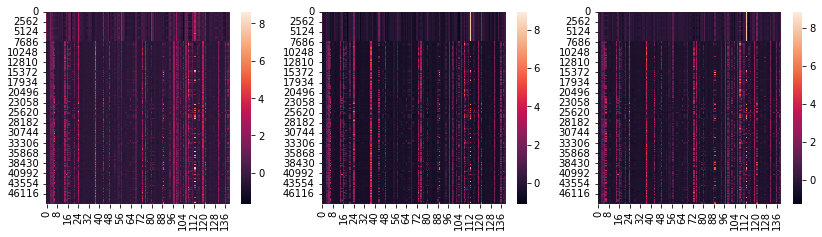

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(14,12))
for id,res in enumerate(tqdm(res_all)):
    plt.subplot(3,3,id+1)
    sns.heatmap(res)
plt.show()

In [18]:
res_all_ = np.mean(res_all,axis=0)

<AxesSubplot:>

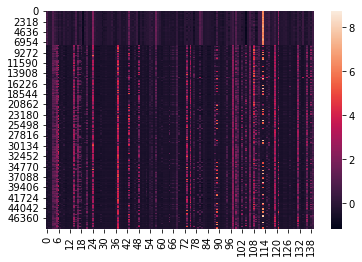

In [19]:
sns.heatmap(res_all_)

In [20]:
def submit(test_pred,multi_path):
    submission = pd.read_csv(multi_path,index_col = 0)
    submission = submission["target"]
    print("data loaded")
    submission.iloc[:len(test_pred.ravel())] = test_pred.ravel()
    assert not submission.isna().any()
    # submission = submission.round(6) # reduce the size of the csv
    print("start -> submission.zip")
    submission.to_csv('submission.zip')
    print("submission__.zip saved!")

In [22]:
%%time
submit(res_all_,multi_path = r"D:\python_project\MSCI\model_ensemble\submission_best.zip")

data loaded
start -> submission.zip
submission__.zip saved!
CPU times: total: 1min 5s
Wall time: 3min 17s
